In [938]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import data_groups
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [939]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [975]:
def gaussian(f, f_0, a, sigma, c, b):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages):    
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    # fitter.set_p0({"a": -0.1, "sigma": 0.5, "c": 0.9})
    fitter.fit()
    
    return fitter

def linear(x, a, b):
    return a*x + b

def get_linear_fit(amplitudes, heights):
    fitter = Fitter(linear)
    fitter.set_absolute_sigma(False)
    fitter.set_data(amplitudes, heights)
    fitter.fit()

    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c
    

In [1109]:
def rf_spectroscopy(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    offsets = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        offset = headers["params"]["rf"]["offset"].to("kHz").magnitude
        offsets.append(offset)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/chasm_avg)
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])
        
        rf_fit = get_gaussian_fit(detunings, rf_avg/chasm_avg)
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

    offsets = np.array(offsets)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)

    xs = offsets
    ys = 1 - ratios
    return xs, ys
    

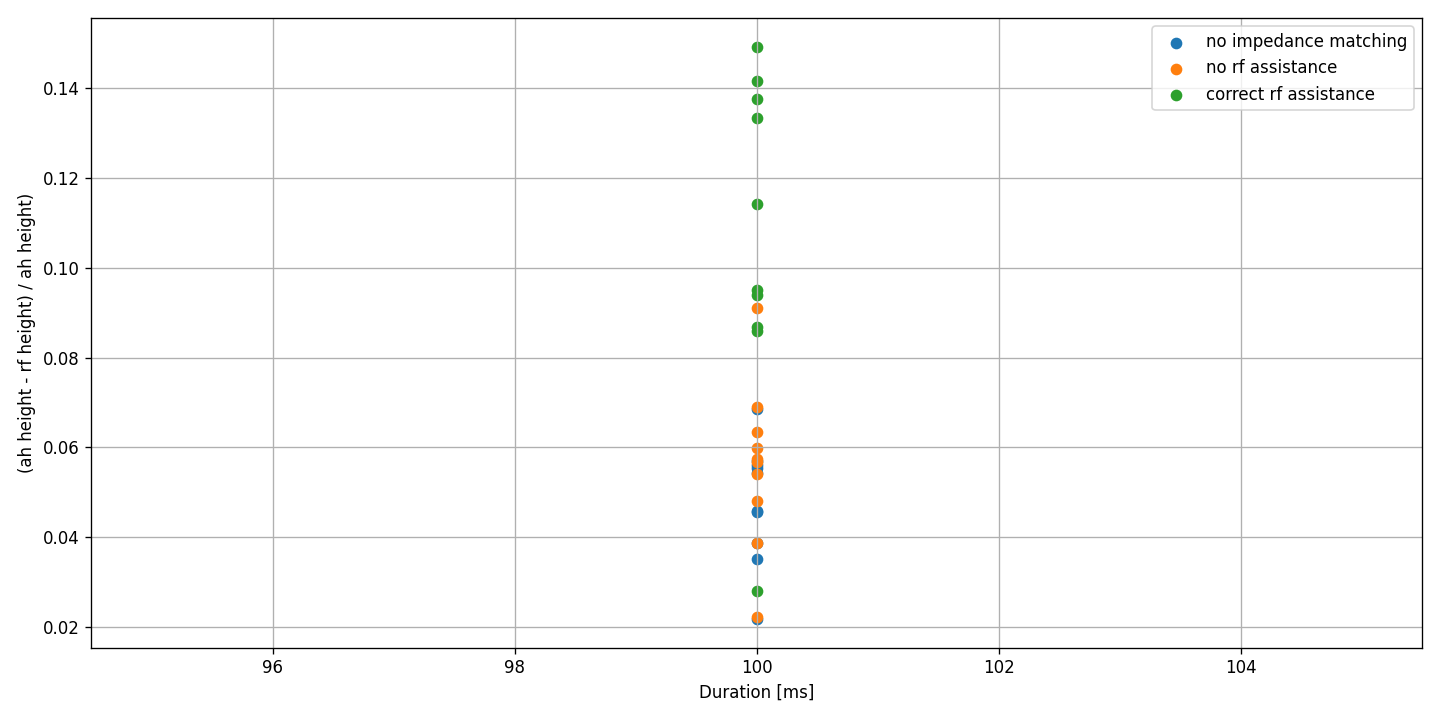

In [1110]:
# data_list = range(3599, 3718)

data = {
    "no impedance matching" : [5654, 5663],
    # # "impedance matching 1" : [5664, 5673], # 10 repeats. below changed to 2 repeats
    # "impedance matching 1" : [5674, 5683],
    # # "impedance matching 2" : [5684, 5693],
    # # "impedance matching 3" : [5694, 5703],
    # "impedance matching 4" : [5704, 5713],
    # "impedance matching 5" : [5714, 5723],
    # "impedance matching 6" : [5724, 5733],
    # # "impedance matching 7" : [5734, 5743],
    # "impedance matching 8" : [5744, 5753],
    # "impedance matching 9" : [5754, 5763],
    # "impedance matching 10" : [5764, 5773],
    # "impedance matching 11" : [5774, 5783],
    # "microwave pumping" : [5784, 5801],
    # "baseline" : [5816, 5825],
    # "microwave assisted pump": [5826, 5835],
    "no rf assistance": [5846, 5855],
    "correct rf assistance": [5856, 5865],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_spectroscopy(data_list)
    ax.scatter(xs, ys, label = label)
    
ax.set_xlabel("Duration [ms]")
ax.set_ylabel("(ah height - rf height) / ah height)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

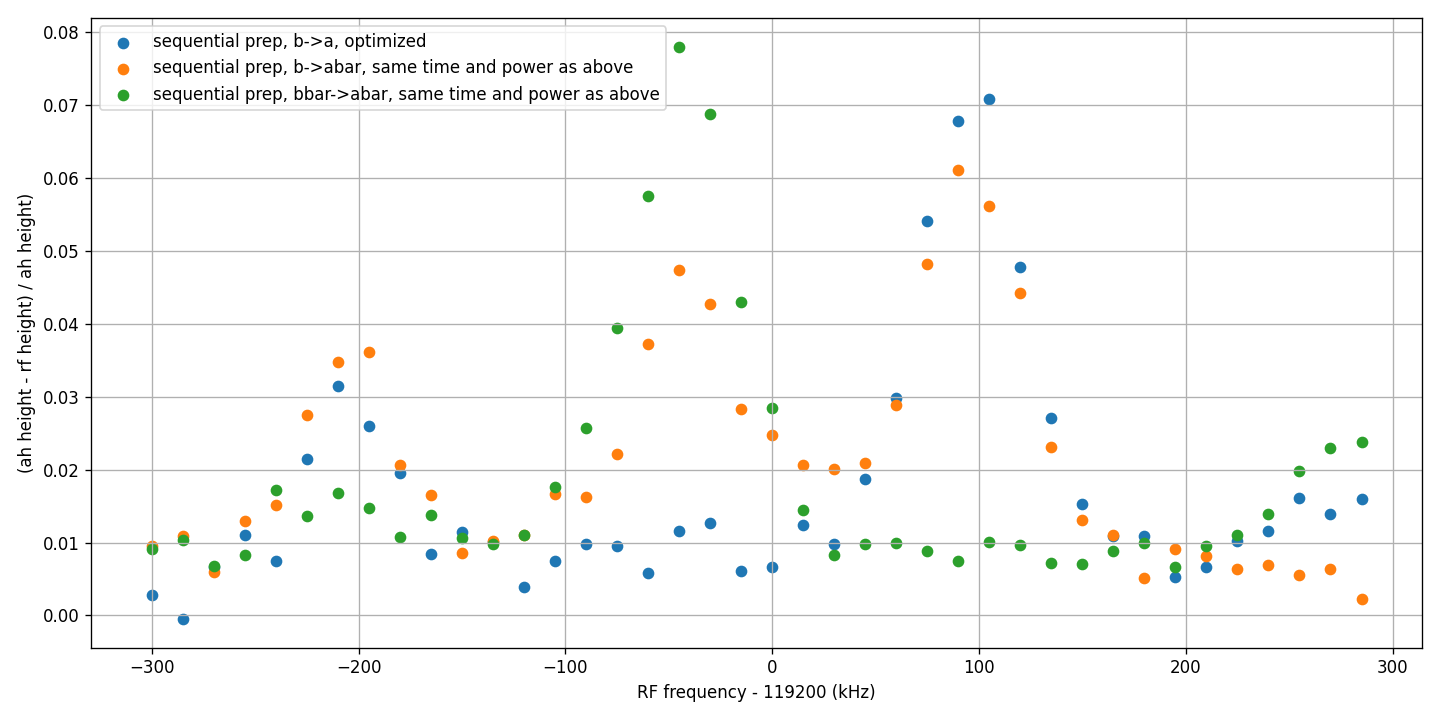

In [1207]:
# data_list = range(3599, 3718)

data = {
    #"simultaneous prep, b->abar" : [5900, 5959],
    # "sequential prep, b->abar, 5 ms" : [6020, 6079],
    #"simultaneous prep, b->abar, confirm" : [6080, 6139],
    # "sequential prep, b->a, 5 ms" : [6153, 6212],
    # "sequential prep, b->a, 20 ms" : [6213, 6243],
    # "sequential prep, b->a, 4x more antihole repeats" : [6245, 6284],
    "sequential prep, b->a, optimized" : [7190, 7229],
    "sequential prep, b->abar, same time and power as above" : [7282, 7321],
    "sequential prep, bbar->abar, same time and power as above" : [7322, 7361],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_spectroscopy(data_list)
    ax.scatter(xs, ys, label = label)
    
ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_ylabel("(ah height - rf height) / ah height)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [1168]:
data, headers = get_experiment_data(6120)

In [1169]:
(chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

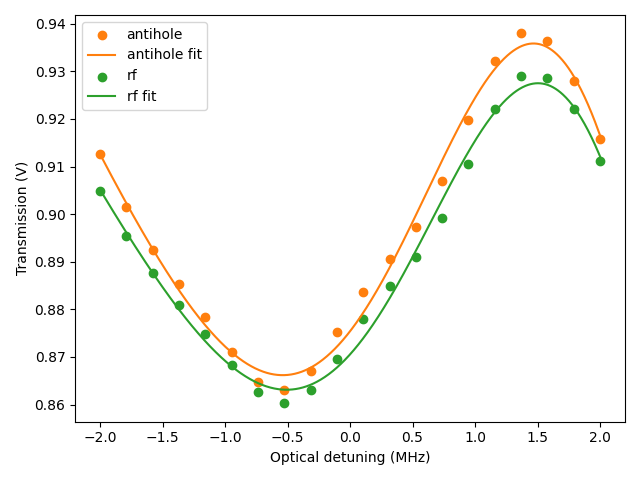

0.22681766827965508
0.025577569997439983
1.2512966384170672
0.08289134752039415


In [1170]:
plt_monitor = False

antihole_normalized = antihole_avg/chasm_avg
rf_normalized = rf_avg/chasm_avg

fig, ax = plt.subplots()
# ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
ax.scatter(detunings_MHz, antihole_normalized, label="antihole", color="C1")

antihole_fit = get_gaussian_fit(detunings_MHz, antihole_normalized)
xaxis = np.linspace(min(detunings_MHz), max(detunings_MHz), 1000)
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    ax.scatter(detunings_MHz, rf_normalized, label="rf", color="C2")
    #ax.scatter(detunings_MHz, np.average(rf_avg, axis=0) / np.average(antihole_avg, axis=0), label="rf / antihole")

    rf_fit = get_gaussian_fit(detunings_MHz, rf_normalized)
    ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.results["a"])
print(antihole_fit.errors["a"])
print(antihole_fit.results["sigma"])
print(antihole_fit.errors["sigma"])